In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#Downloading stopwords 
#Stopwords are the words in any language which does not add much meaning to a sentence.
#They can safely be ignored without sacrificing the meaning of the sentence.
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

ps = PorterStemmer()

from wordcloud import WordCloud

In [2]:
data_path = 'C:/Users/amahbub/Documents/personal/misinformation_hackathon/dataset_3/'
df_train = pd.read_csv(data_path+'train.csv')
df_test = pd.read_csv(data_path+'test.csv') #no label included, so unusable
df = df_train

In [3]:
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

# Data preprocessing and cleaning

In [4]:
#filling NULL values with empty string
df=df.fillna('')

# Data Analysis: Getting intuition using word cloud

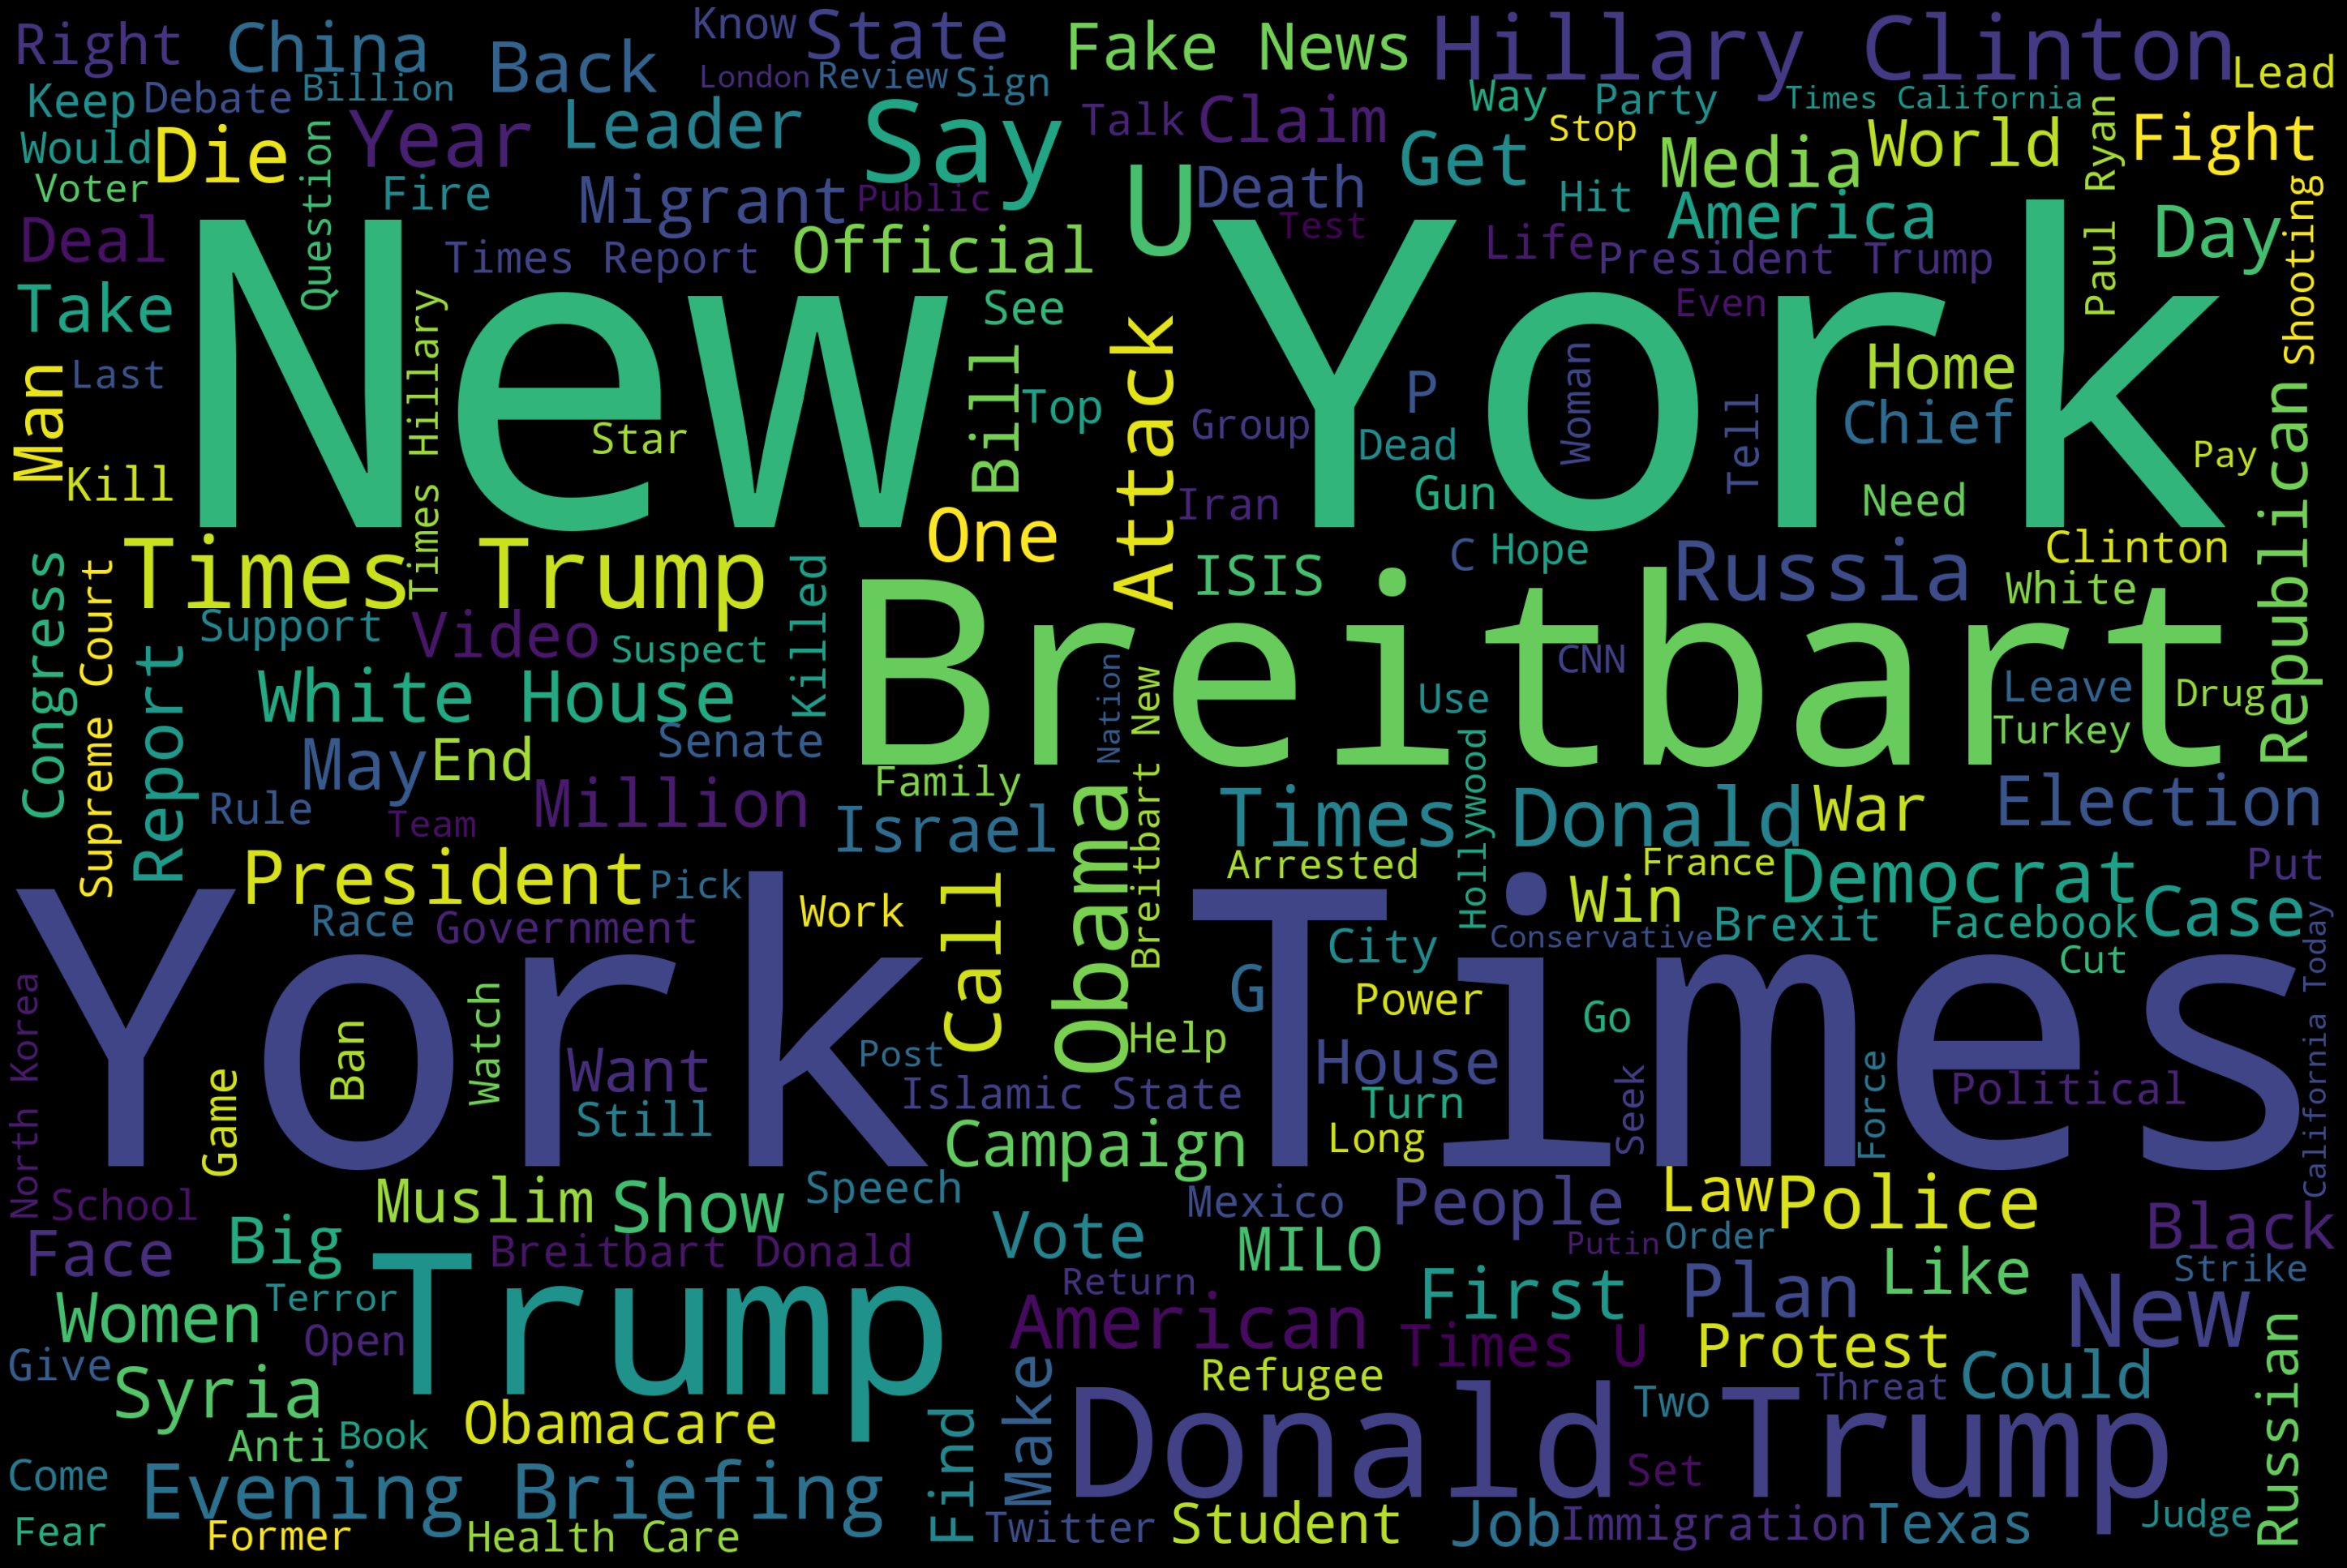

In [5]:
# Preparing the word cloud for the real news article to order to understand type of words in real news
# (column : title of the news)

real = df[df['label']==0]
real.shape

text = ''
for news in real.title.values:
    text += f" {news}"  # f will help to retain the text as a string
wordcloud = WordCloud(width = 3000,height = 2000, background_color = 'black',
                      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# In this real news articles there is mention of publisher : (eg : Newyork times) in some articles

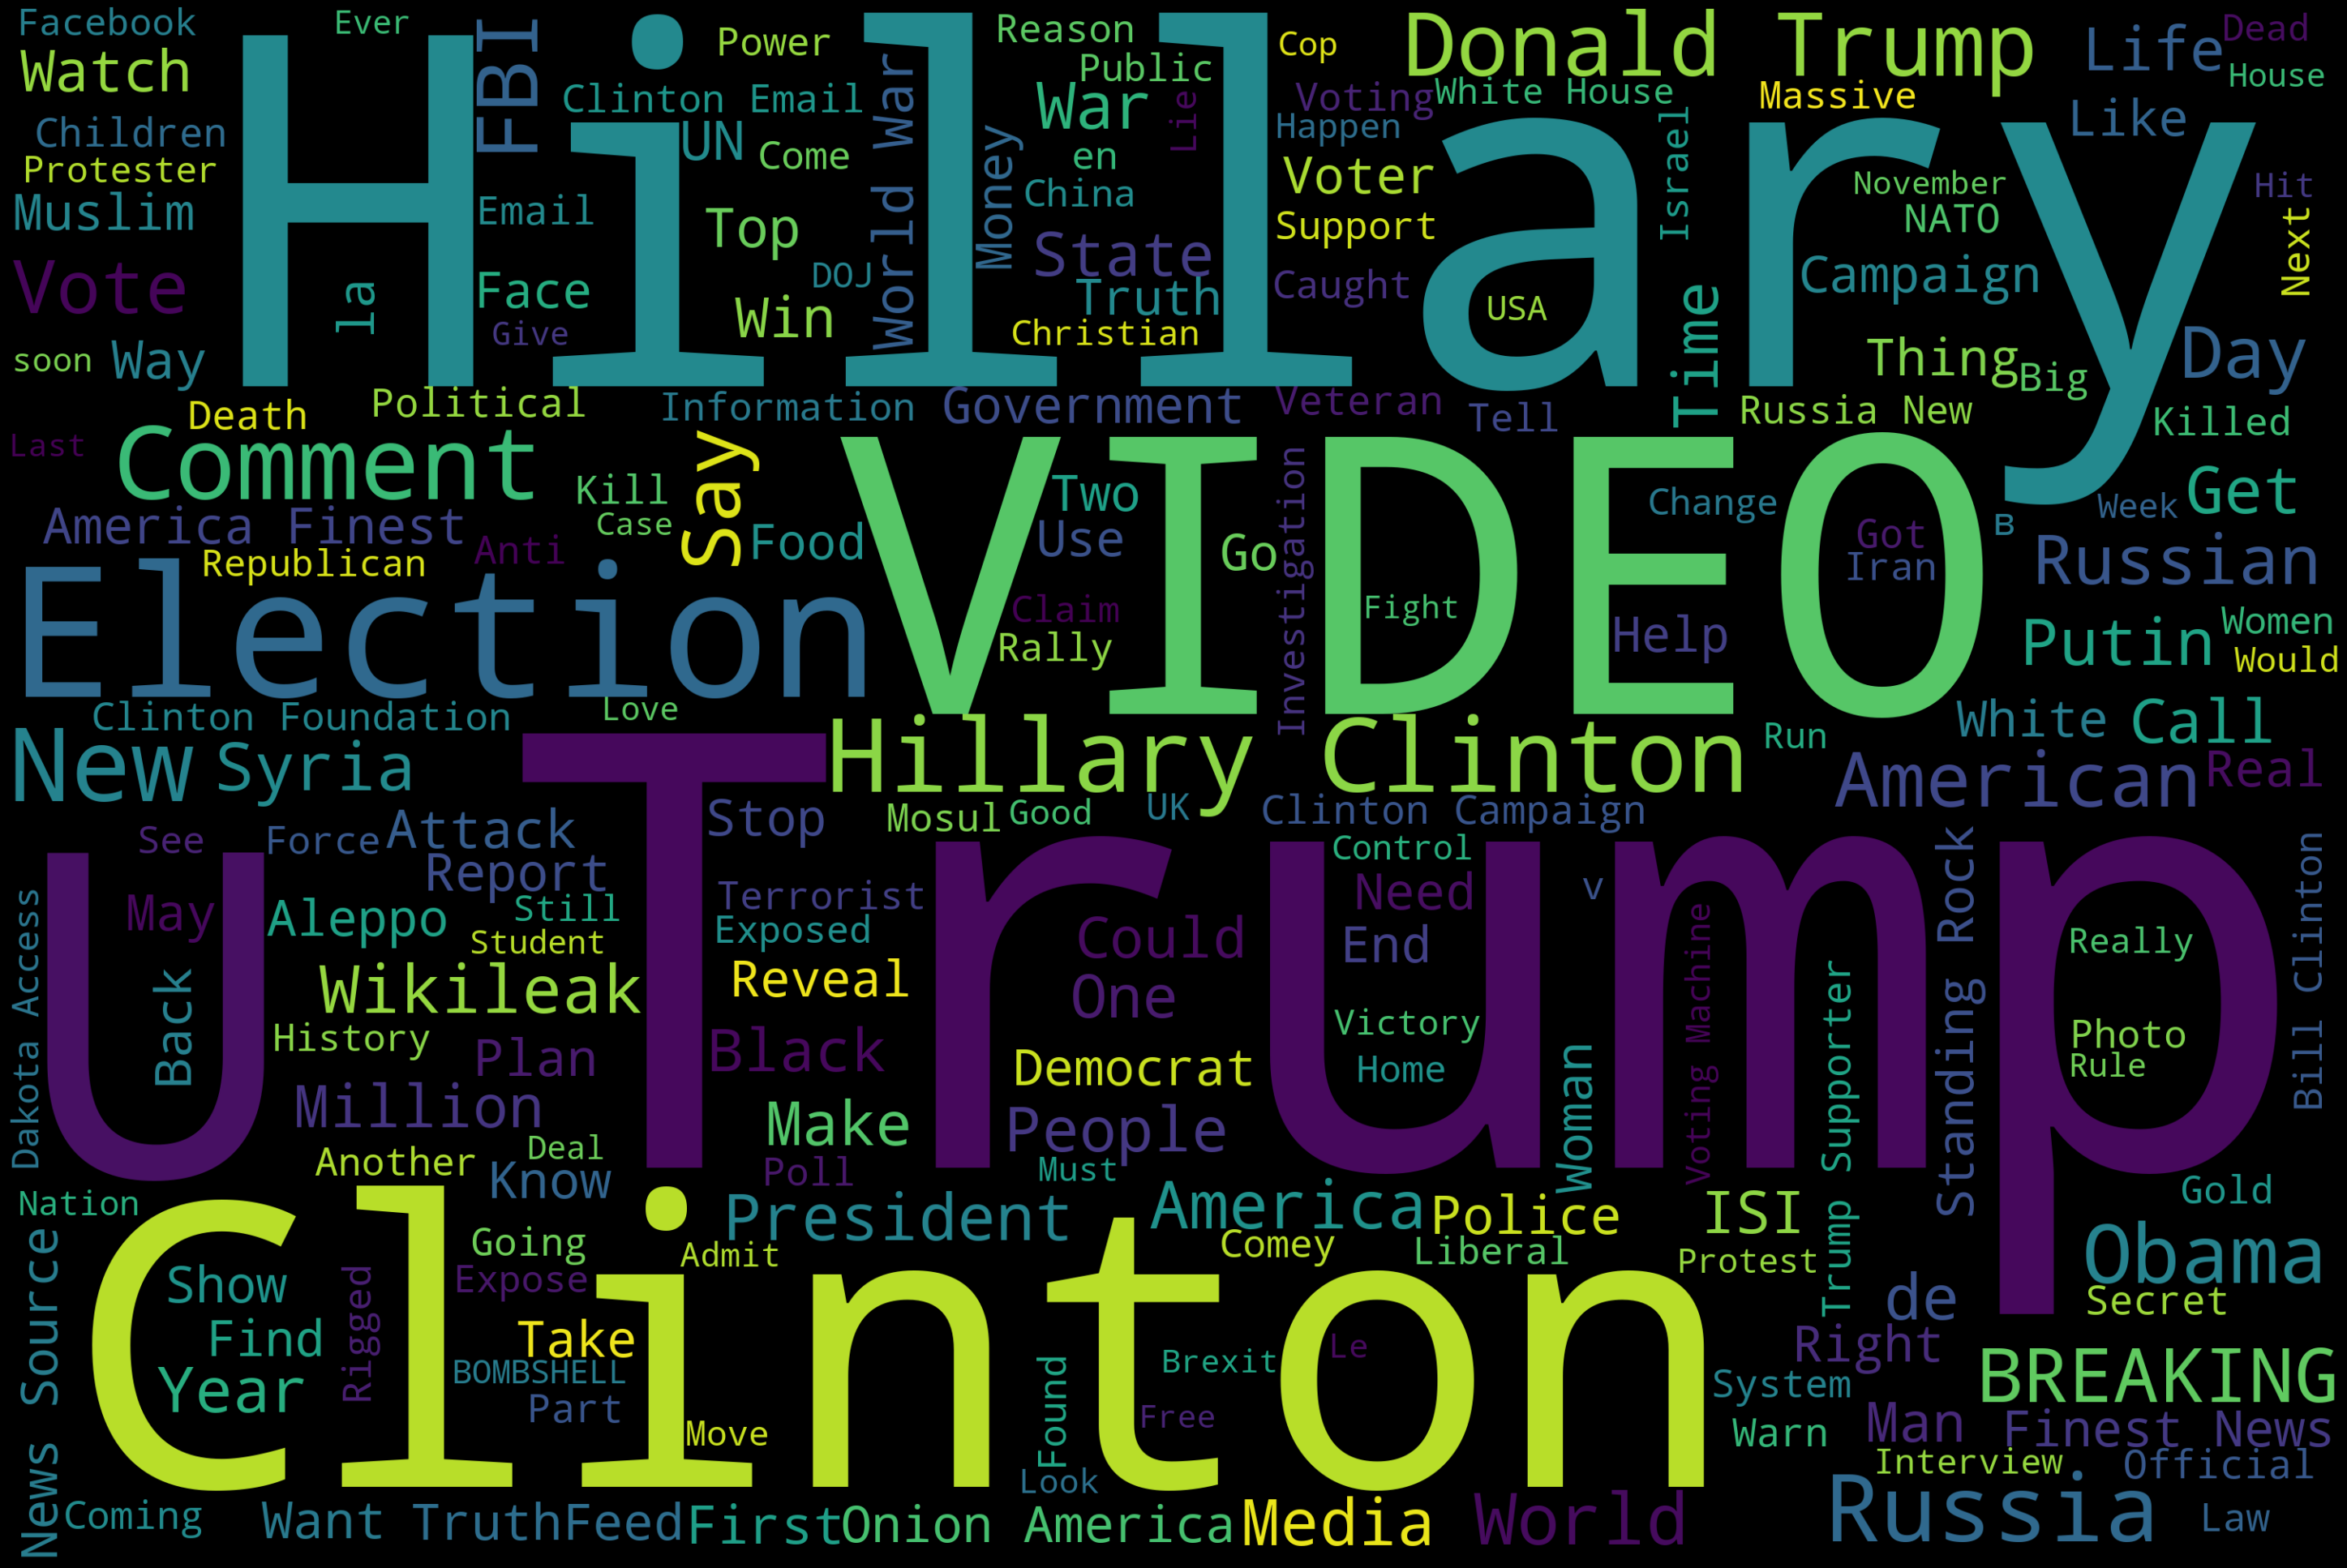

In [6]:
# Preparing the word cloud for fake news article to order to understand type of words in fake news
# (column : title)

fake = df[df['label']==1]
fake.shape

text = ''
for news in fake.title.values:
    text += f" {news}"  # f will help to retain the text as a string
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# In this articles there is no mention of any publisher in the fake news 

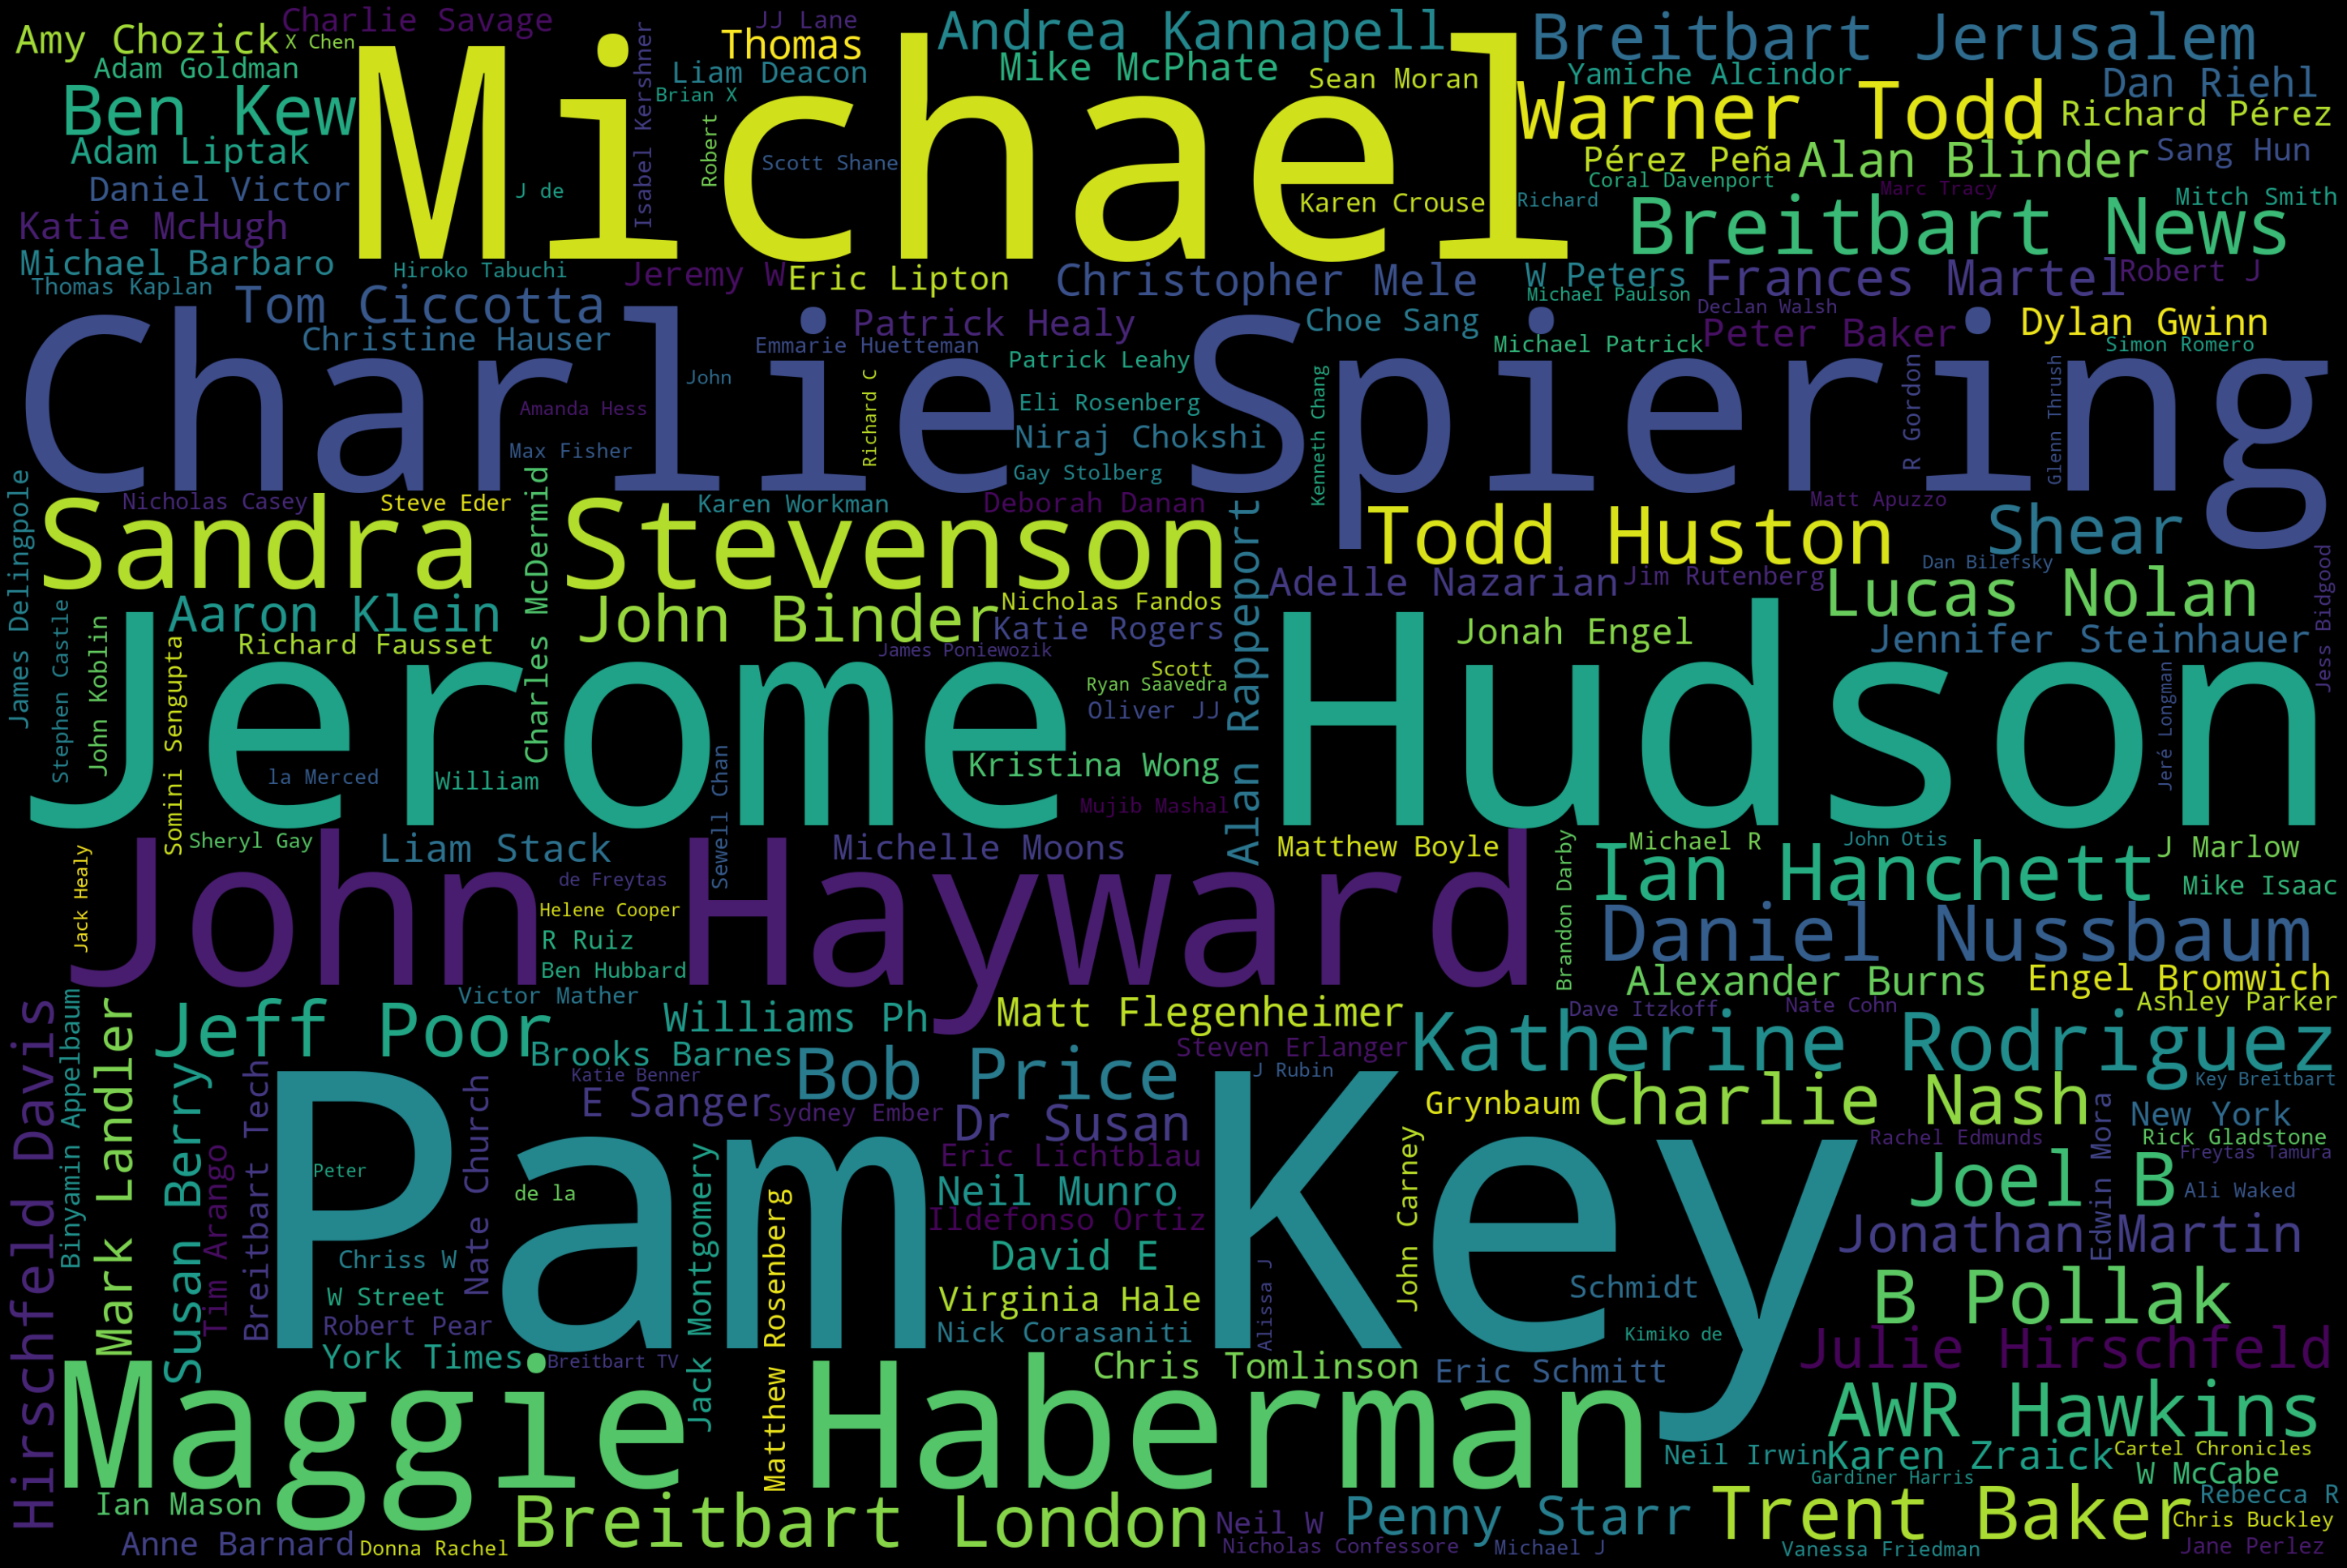

In [7]:
# Preparing the word cloud for real news article to check distribution of words in real author names
# column : Author

text = ''
for news in real.author.values:
    text += f" {news}"  # f will help to retain the text as a string
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# We can see mention of real author names in the real news articles

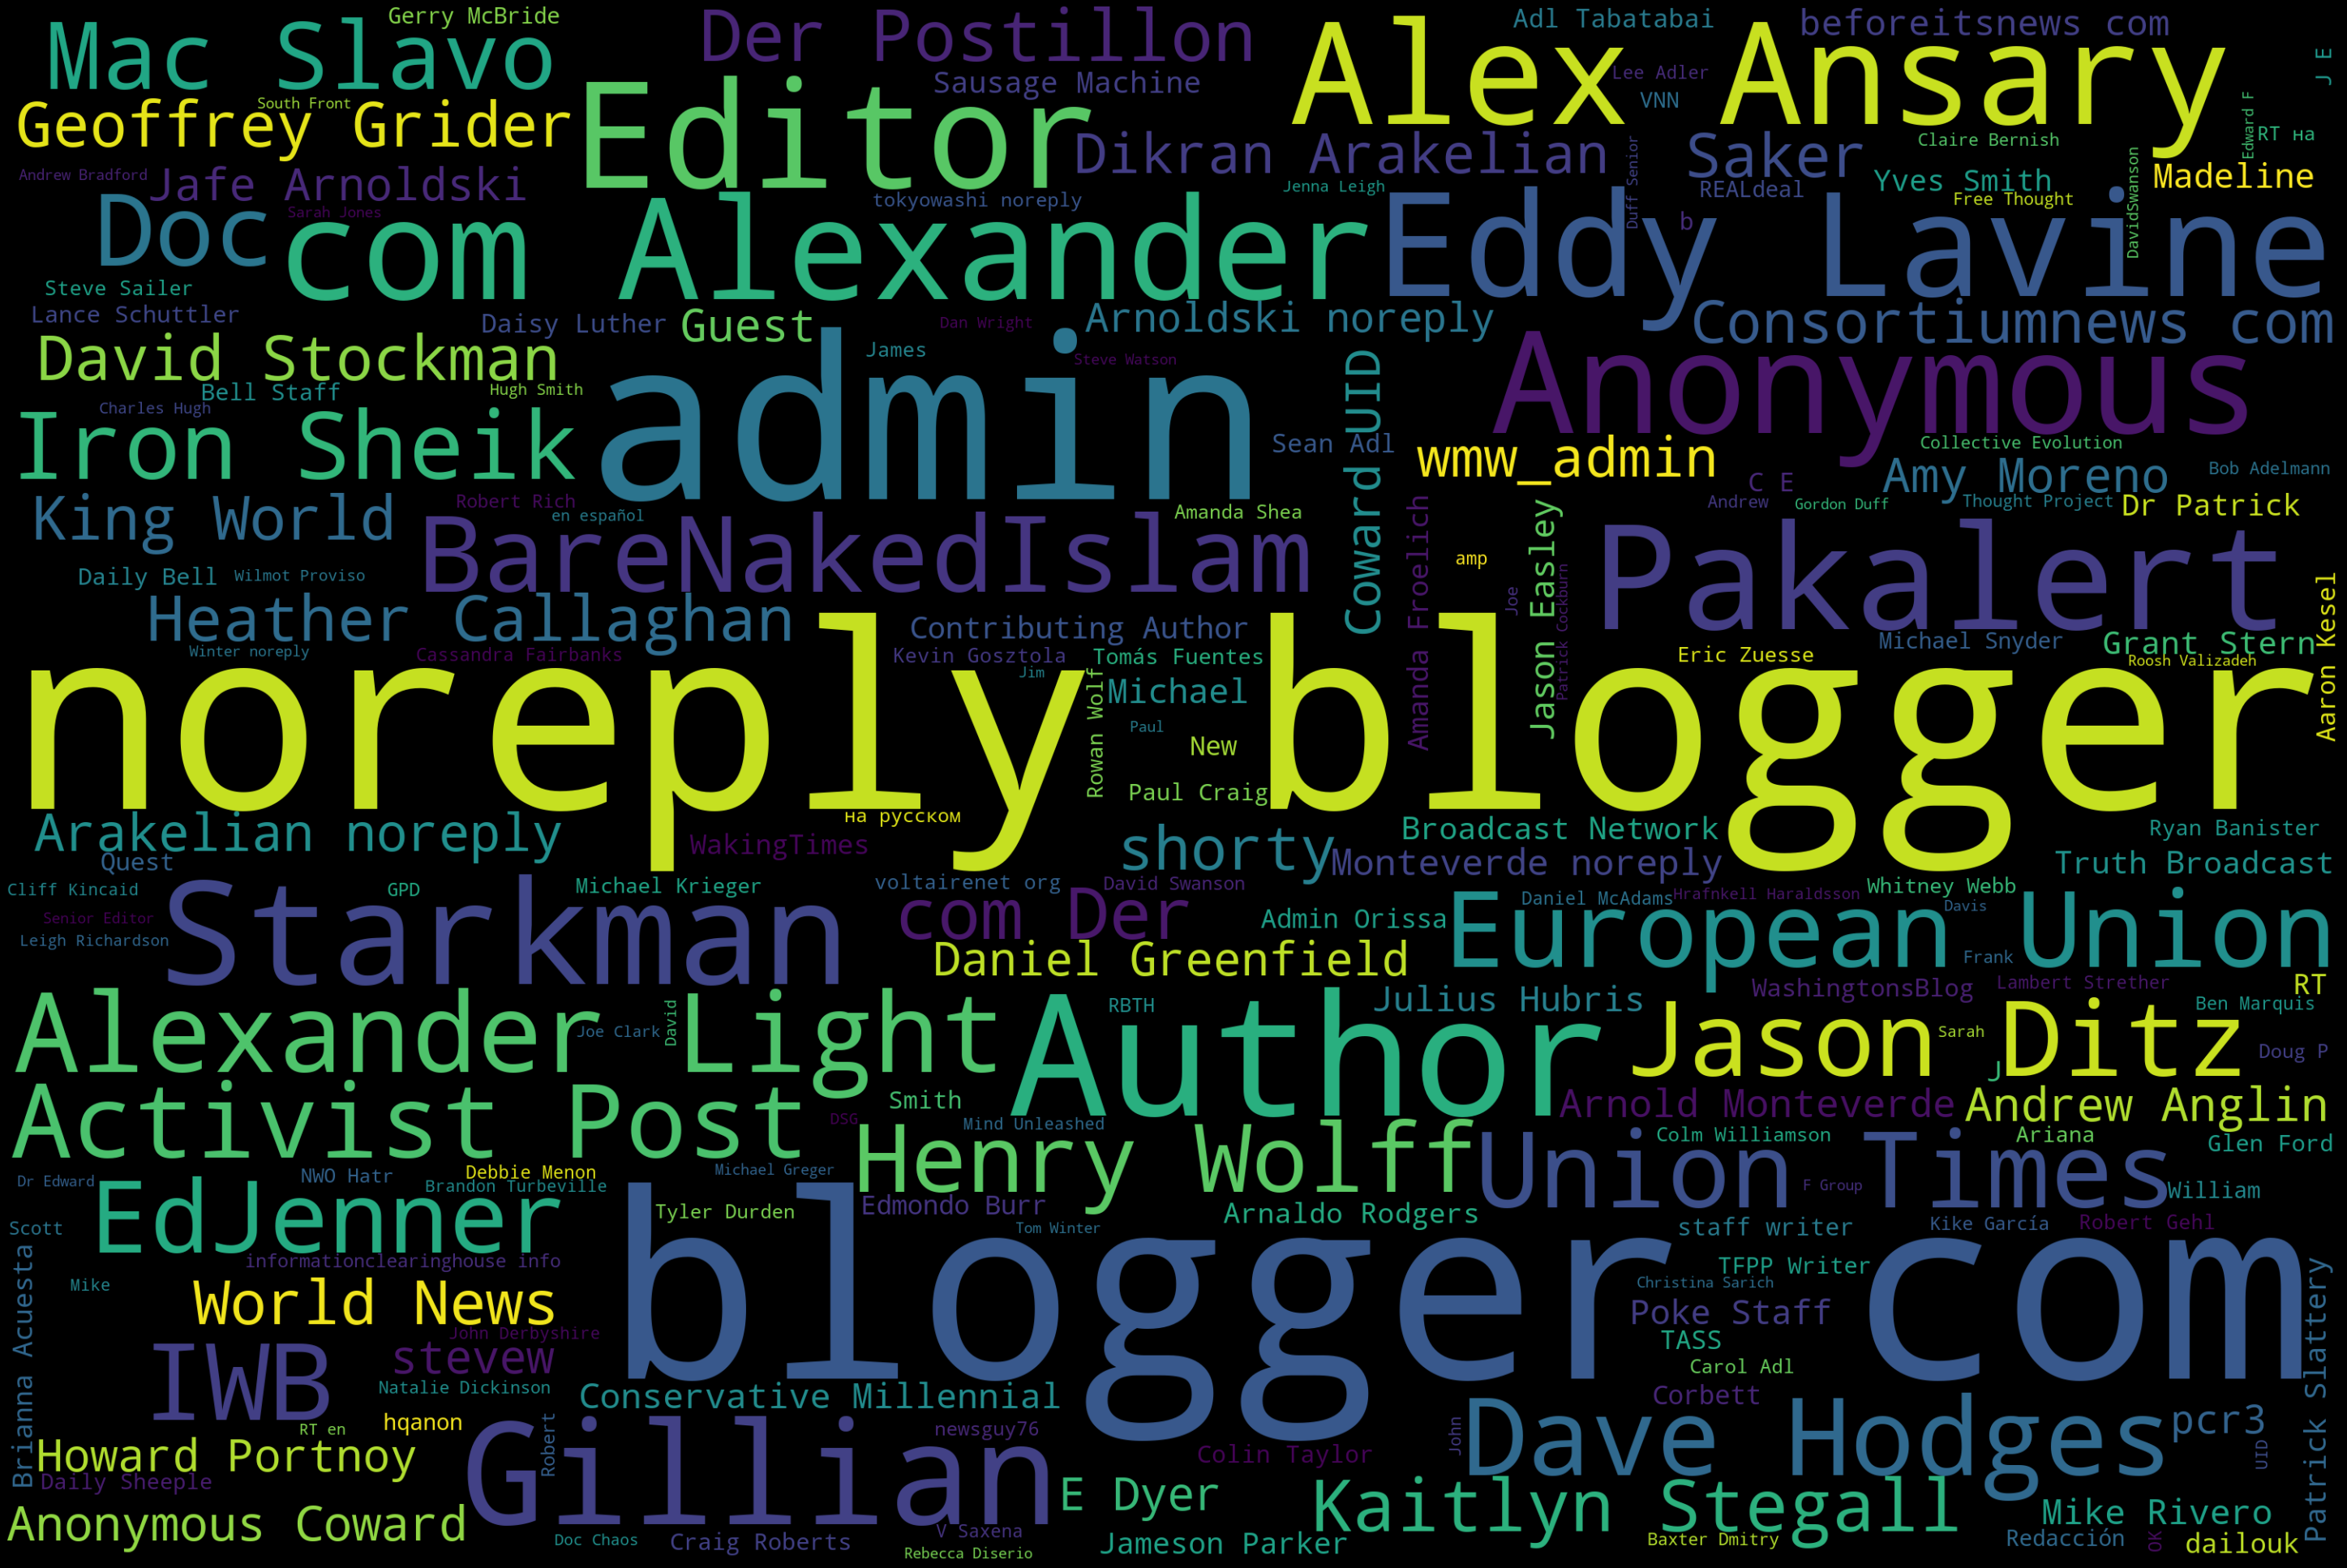

In [8]:
# Preparing the word cloud for fake news article to check distribution of words in fake author names
# column : author

text = ''
for news in fake.author.values:
    text += f" {news}"  # f will help to retain the text as a string
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# In this fake news article, the author names are hidden in the form of blogger, editor, anonymous, no reply, activist, post, admin, editor...

# Feature Manipulation+ label segregation

In [9]:
# Creating a new independent variable  : concatenating author and title column
# This new independent variable (creating using author and title column) would be perform better in classifying the real and fake news instead of taking an individual variable
# Will use this new independent variable in building the model
# We will be only using title and author name for prediction
# Creating new coolumn total concatenating title and author
df['total'] = df['title']+' '+df['author']

In [10]:
y=df['label']
X = df.drop('label',axis=1)
X.columns

Index(['id', 'title', 'author', 'text', 'total'], dtype='object')

# Text processing
1.Removing special characters and numbers

2.Converting into lowercase to develop a consistent data

3.Tokenize the text, ignoring stopwords and performing stemming on the words

In [11]:
#Downloading stopwords 
#Stopwords are the words in any language which does not add much meaning to a sentence.
#They can safely be ignored without sacrificing the meaning of the sentence.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amahbub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Test-train Split

In [12]:
df_test.head()

id                                              title  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1  20801  Russian warships ready to strike terrorists ne...   
2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
4  20804                    Keiser Report: Meme Wars (E995)   

                    author                                               text  
0         David Streitfeld  PALO ALTO, Calif.  —   After years of scorning...  
1                      NaN  Russian warships ready to strike terrorists ne...  
2            Common Dreams  Videos #NoDAPL: Native American Leaders Vow to...  
3            Daniel Victor  If at first you don’t succeed, try a different...  
4  Truth Broadcast Network  42 mins ago 1 Views 0 Comments 0 Likes 'For th...

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Method 1: Using Only Title + Author

# Stemming

Stemming means elimination of affix. Instead of saving all shape of words, a stemmed word can reduce the size of index and increase the accuracy.

- PorterStemmer
It eliminates the suffix.

- LancasterStemmer:
It is similar to ProterStemmer, but the performance is better.

presumably -> presum
cement -> cem
owed -> ow
ear -> ear

- SnowballStemmer:
It supports for the 13 languages except for English.

Autobahnen -> autobahn</n>

- WordNetLemmatizer

dogs -> dog
churches -> church
abaci -> abacus

In [14]:
corpus_train=[]
for i in range(len(X_train)):
#     if i == 20800: continue
    input1 = re.sub('[^a-zA-Z]',' ', str(X_train.iloc[i].total)) # except a-z and A-Z, substitute all other characters with ' '
    input1 = input1.lower() # Lower case 
    input1  = input1.split() # tokenize the text
    input1= [ps.stem(word) for word in input1 if word not in stopwords.words('english')]
    text = ' '.join(input1)  # concatenating all words into a single text (list is created)#
    corpus_train.append(text) # appending text into a single corpus #
len(corpus_train)

#dip: b'[^a-zA-Z]' 

16640

In [15]:
corpus_test=[]
for i in range(len(X_test)):
#     if i == 20800: continue
    input1 = re.sub('[^a-zA-Z]',' ', str(X_test.iloc[i].total)) # except a-z and A-Z, substitute all other characters with ' '
    input1 = input1.lower() # Lower case 
    input1  = input1.split() # tokenize the text
    input1= [ps.stem(word) for word in input1 if word not in stopwords.words('english')]
    text = ' '.join(input1)  # concatenating all words into a single text (list is created)#
    corpus_test.append(text) # appending text into a single corpus #
len(corpus_test)

4160

# # Converting to one hot representation

In [16]:
#Choosing vocabulary size to be 5000 and copying data to msg for further cleaning
voc_size = 5000
onehot_rep_train = [one_hot(words,voc_size)for words in corpus_train]
onehot_rep_test = [one_hot(words,voc_size)for words in corpus_test]

In [17]:
#Padding Sentences to make them of same size
embedded_docs = pad_sequences(onehot_rep_train,padding='pre',maxlen=25)
embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=25)

# Building LSTM model

In [18]:
#We have used embedding layers with LSTM
model = Sequential()
model.add(Embedding(voc_size,40,input_length=25))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [19]:
#Converting into numpy array
X_final = np.array(embedded_docs)
y_final = np.array(y_train)
test_final = np.array(embedded_docs_test)
X_final.shape,y_final.shape,test_final.shape

((16640, 25), (16640,), (4160, 25))

In [20]:
print(type(X_final))
print(type(y_final))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
#training model
model.fit(X_final,y_final,epochs=20,batch_size=64)

Train on 16640 samples
Epoch 1/20
16640/16640 [==============================] - 7s 406us/sample - loss: 0.1729 - accuracy: 0.9290
Epoch 2/20
16640/16640 [==============================] - 5s 292us/sample - loss: 0.0203 - accuracy: 0.9940
Epoch 3/20
16640/16640 [==============================] - 5s 312us/sample - loss: 0.0083 - accuracy: 0.9980
Epoch 4/20
16640/16640 [==============================] - 5s 321us/sample - loss: 0.0048 - accuracy: 0.9987
Epoch 5/20
16640/16640 [==============================] - 6s 334us/sample - loss: 0.0030 - accuracy: 0.9991
Epoch 6/20
16640/16640 [==============================] - 6s 342us/sample - loss: 0.0026 - accuracy: 0.9990
Epoch 7/20
16640/16640 [==============================] - 6s 343us/sample - loss: 0.0021 - accuracy: 0.9995
Epoch 8/20
16640/16640 [==============================] - 6s 342us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 9/20
16640/16640 [==============================] - 6s 341us/sample - loss: 0.0012 - accuracy: 0.9998
Epoch

In [22]:
y_pred = model.predict_classes(test_final)

accuracy=accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.989423076923077


# Method 2: Using Text body of the article

In [23]:
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amahbub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def ntlk_process(text):
    text = text.lower()
    
    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub(r"'s", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    
    tokens = []
    for token in text.split():
        if token not in stopwords.words('english'):
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

In [25]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))
df['text'] = df['text'].apply(lambda x: remove_html(x))
df['text'] = df['text'].apply(lambda x: remove_emoji(x))
df['text'] = df['text'].apply(lambda x: ntlk_process(x))

KeyboardInterrupt: 

In [26]:
X = df.text
X.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    Ever get the feeling your life circles the rou...
2    Why the Truth Might Get You Fired October 29, ...
3    Videos 15 Civilians Killed In Single US Airstr...
4    Print \nAn Iranian woman has been sentenced to...
Name: text, dtype: object

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
voc_size = len(tokenizer.word_index) + 1
print('vocabulary size: {}'.format(voc_size))

vocabulary size: 210303


In [29]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = 256)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = 256)

In [30]:
inputs = Input(shape=(256,), dtype='int32')

model = Sequential(
    [Embedding(voc_size, 500),
    SpatialDropout1D(0.2),
    LSTM(256),
    Dropout(0.3),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid'),]
)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 500)         105151500 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 500)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               775168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=3, batch_size=64)

Train on 16640 samples, validate on 4160 samples
Epoch 1/3
16640/16640 [==============================] - 850s 51ms/sample - loss: 0.2899 - accuracy: 0.8796 - val_loss: 0.2012 - val_accuracy: 0.9228
Epoch 2/3
16640/16640 [==============================] - 853s 51ms/sample - loss: 0.0947 - accuracy: 0.9666 - val_loss: 0.1994 - val_accuracy: 0.9445
Epoch 3/3
 1408/16640 [=>............................] - ETA: 13:21 - loss: 0.0354 - accuracy: 0.9915